## Data Incubator Challenge - Code

The following is the code used to perform exploratory data analysis on the data for the data incubator challenge. The project proposal relies on crawling and scraping information from multiple public sources including hospital websites, medical sites, and other public information about conditions
and where they are treated.

In [72]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from PIL import Image
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
import math
%matplotlib inline

In [73]:
import nltk
#download stop words. to be used for filtering medical terms
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/agamino/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [74]:
#Stop words to filter 
stop_words = set(stopwords.words('english'))

In [75]:
#Source: https://github.com/glutanimate/wordlist-medicalterms-en
#Load medical terms, this will be use to filter out everything else
medical_terms = set(line.strip() for line in open('medical_terms.txt'))

In [76]:
#Read file with all hospital addresses and urls
#Source: Homeland Infrastructure Foundation - Level Data
#https://respond-irma-geoplatform.opendata.arcgis.com/datasets/hospitals/geoservice
df_addresses = pd.read_excel("hospital_with_addresses.xlsx")

In [77]:
#Check size
df_addresses.shape

(7030, 38)

In [78]:
#Check how many terms were loaded
len(medical_terms)

98112

In [79]:
#This file contains a list of url paths that were found on crawling
#hundreds of hospital sites.
#Will be used to extract those urls that contain medical terms
df = pd.read_excel("HospitalSites_level_name.xlsx")

In [80]:
#Check size
df.shape

(1048575, 4)

In [81]:
#Show first elements
df.head()

,domain,level,level_count,level_name
0,www.advocatechildrenshospital.com,1,35,documents
1,www.advocatechildrenshospital.com,1,15,cmc
2,www.advocatechildrenshospital.com,1,11,luth
3,www.advocatechildrenshospital.com,1,10,gsam
4,www.advocatechildrenshospital.com,1,8,ach-care-treatment


In [82]:
#Show how many links per domain
df['domain'].value_counts()

www.altabatessummit.org                 122252
www.gottliebhospital.org                109346
www.arnoldpalmerhospital.com             72525
www.advocatehealth.com                   66748
www.hopkinsmedicine.org                  34970
hospital.uillinois.edu                   27359
goodsamsanjose.com                       25818
www.kumc.edu                             20499
www.baptistjax.com                       15298
www.kentuckyonehealth.org                15107
www.ucirvinehealth.org                   13756
www.adventisthealth.org                  13724
nyulangone.org                           13695
www.chp.edu                              13476
www.akronchildrens.org                   12684
www.emmc.org                             12038
home.llu.edu                             12029
www.hoag.org                             11828
www.stmarygj.org                         10938
www.stjudemedicalcenter.org              10921
www.mercy-chicago.org                    10533
www.presenceh

In [83]:
#function to extract terms from URLs, remove extra information from urls
#and keep only medical terms
def only_medical_terms(level_name):
    #First split them into words
    level_name = str(level_name)
    results = []
    tokens = level_name.split("?")
    for t in tokens:
        s = t.split("-")
        for s1 in s:
            e = s1.split("&")
            for s2 in e:
                r = s2.split("=")
                for s3 in r:
                    if(s3 in medical_terms and s3 not in stop_words):
                        results.append(s3)
                        
    if(len(results)==0):
        results = np.nan
    return results

In [84]:
#Add a column from urls to extract medical terms
df['terms'] = df['level_name'].apply(only_medical_terms)

In [85]:
#check size
df.shape

(1048575, 5)

In [86]:
#check first few rows
df.head()

,domain,level,level_count,level_name,terms
0,www.advocatechildrenshospital.com,1,35,documents,NaN
1,www.advocatechildrenshospital.com,1,15,cmc,NaN
2,www.advocatechildrenshospital.com,1,11,luth,[luth]
3,www.advocatechildrenshospital.com,1,10,gsam,NaN
4,www.advocatechildrenshospital.com,1,8,ach-care-treatment,"[care, treatment]"


In [87]:
#Drop were no terms were found
df.dropna(inplace=True)

In [88]:
#check remaining shape
df.shape

(470814, 5)

In [89]:
#extact only the domains(urls) and terms
df_domain_terms = df[['domain','terms']]

In [90]:
#check first few terms
df_domain_terms.head()

,domain,terms
2,www.advocatechildrenshospital.com,[luth]
4,www.advocatechildrenshospital.com,"[care, treatment]"
17,www.advocatechildrenshospital.com,"[center, fetal, care]"
19,www.advocatechildrenshospital.com,"[radiation, oncology]"
22,www.advocatechildrenshospital.com,[form]


In [91]:
#group by domain and concatenate terms
df_grouped_by_domain = df_domain_terms.groupby('domain').apply(lambda x: x.sum())

In [92]:
#rename index from domain to url
#remove extra 'domain' column
df_grouped_by_domain.index.names = ['url']
df.drop('domain', axis=1, inplace=True)

In [93]:
#reset index
df_grouped_by_domain.reset_index(drop=False, inplace=True)

In [94]:
#removed extra domain
df_grouped_by_domain.drop('domain', axis=1, inplace=True)

In [95]:
#show first rows
df_grouped_by_domain.head()

,url,terms
0,goodsamsanjose.com,"[site, legal, profile, general, surgery, rehab..."
1,home.llu.edu,"[explore, lomalinda, bioethics, make, site, st..."
2,hospital.uillinois.edu,"[doctor, primary, specialty, care, doctor, doc..."
3,mercymiami.com,"[legal, get, america, profile, school, practic..."
4,mylrh.org,"[component, cancer, center, rehab, recognition..."


In [96]:
#Calculatd number of terms
df_grouped_by_domain['number_of_terms'] = df_grouped_by_domain.terms.apply(lambda x: len(x))

In [97]:
df_grouped_by_domain.head()

,url,terms,number_of_terms
0,goodsamsanjose.com,"[site, legal, profile, general, surgery, rehab...",12012
1,home.llu.edu,"[explore, lomalinda, bioethics, make, site, st...",65
2,hospital.uillinois.edu,"[doctor, primary, specialty, care, doctor, doc...",99172
3,mercymiami.com,"[legal, get, america, profile, school, practic...",752
4,mylrh.org,"[component, cancer, center, rehab, recognition...",1086


In [98]:
#Some are repeated, remove repeated terms
df_grouped_by_domain['unique_terms'] = df_grouped_by_domain.terms.apply(lambda x: set((x)))

In [99]:
df_grouped_by_domain.head()

,url,terms,number_of_terms,unique_terms
0,goodsamsanjose.com,"[site, legal, profile, general, surgery, rehab...",12012,"{spring, cerebellar, neurosurgery, temporomand..."
1,home.llu.edu,"[explore, lomalinda, bioethics, make, site, st...",65,"{code, course, clin, lomalinda, site, withdraw..."
2,hospital.uillinois.edu,"[doctor, primary, specialty, care, doctor, doc...",99172,"{maternity, symptoms, dental, neurosurgery, no..."
3,mercymiami.com,"[legal, get, america, profile, school, practic...",752,"{anesthesiology, maternity, Paul, behavioral, ..."
4,mylrh.org,"[component, cancer, center, rehab, recognition...",1086,"{spring, gender, winter, neurosurgery, non, cr..."


In [100]:
#Add counter for number of unique terms
df_grouped_by_domain['number_of_unique'] = df_grouped_by_domain.unique_terms.apply(lambda x: len(x))

In [101]:
df_grouped_by_domain.head()

,url,terms,number_of_terms,unique_terms,number_of_unique
0,goodsamsanjose.com,"[site, legal, profile, general, surgery, rehab...",12012,"{spring, cerebellar, neurosurgery, temporomand...",2438
1,home.llu.edu,"[explore, lomalinda, bioethics, make, site, st...",65,"{code, course, clin, lomalinda, site, withdraw...",31
2,hospital.uillinois.edu,"[doctor, primary, specialty, care, doctor, doc...",99172,"{maternity, symptoms, dental, neurosurgery, no...",532
3,mercymiami.com,"[legal, get, america, profile, school, practic...",752,"{anesthesiology, maternity, Paul, behavioral, ...",130
4,mylrh.org,"[component, cancer, center, rehab, recognition...",1086,"{spring, gender, winter, neurosurgery, non, cr...",283


In [102]:
#At this point we have url, and terms ready to be merge
df_sites_terms = df_grouped_by_domain[['url','unique_terms','number_of_unique']]
df_sites_terms.columns = ['url', 'terms','number_of_terms']

In [103]:
df_sites_terms.head()

,url,terms,number_of_terms
0,goodsamsanjose.com,"{spring, cerebellar, neurosurgery, temporomand...",2438
1,home.llu.edu,"{code, course, clin, lomalinda, site, withdraw...",31
2,hospital.uillinois.edu,"{maternity, symptoms, dental, neurosurgery, no...",532
3,mercymiami.com,"{anesthesiology, maternity, Paul, behavioral, ...",130
4,mylrh.org,"{spring, gender, winter, neurosurgery, non, cr...",283


In [104]:
#extract only most important columns from addresses dataframe
df_addresses_cleaned = df_addresses[['url', 'NAME', 'ADDRESS', 'CITY','STATE', 'ZIP', 'POPULATION',
       'COUNTY', 'COUNTYFIPS', 'LATITUDE', 'LONGITUDE','NAICS_CODE', 'NAICS_DESC', 'SOURCE','VAL_DATE', 'WEBSITE', 'STATE_ID', 'ST_FIPS', 'OWNER',
       'BEDS']]

In [105]:
df_addresses_cleaned.shape

(7030, 20)

In [106]:
#drop duplicate urls (some hospitals have same URL when they have different location)
df_addresses_cleaned.drop_duplicates(['url'], keep='first', inplace=True)

/Users/agamino/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [107]:
df_addresses_cleaned.shape

(4674, 20)

In [108]:
df_addresses_cleaned.head()

,url,NAME,ADDRESS,CITY,STATE,ZIP,POPULATION,COUNTY,COUNTYFIPS,LATITUDE,LONGITUDE,NAICS_CODE,NAICS_DESC,SOURCE,VAL_DATE,WEBSITE,STATE_ID,ST_FIPS,OWNER,BEDS
0,www.chw.org,CHILDRENS HSPTL OF WISCONSIN FOX VALLEY,130 SECOND ST,Neenah,WI,54956,42,Winnebago,55139,44.1871,-88.4544,622210,"Children'S Hospitals, General",http://www.dhs.wisconsin.gov/bqaconsumer/healt...,2014-03-12T00:00:00.000Z,http://www.chw.org,1005,55,Non-profit,42
2,www.aurorahealthcare.com,AURORA MED CTR OSHKOSH,855 N WESTHAVEN DRIVE,Oshkosh,WI,54904,61,Winnebago,55139,44.0277,-88.5952,622210,General Medical And Surgical Hospitals,http://www.dhs.wisconsin.gov/bqaconsumer/healt...,2014-02-10T00:00:00.000Z,http://www.aurorahealthcare.com,307,55,Non-profit,61
3,www.affinityhealth.org,MERCY MED CTR OF OSHKOSH,500 S OAKWOOD RD,Oshkosh,WI,54904,157,Winnebago,55139,44.0124,-88.6010,622210,General Medical And Surgical Hospitals,http://www.dhs.wisconsin.gov/bqaconsumer/healt...,2014-02-10T00:00:00.000Z,http://www.affinityhealth.org,186,55,Non-profit,157
6,www.riverviewhospital.org,RIVERVIEW HSPTL ASSOC,410 Dewey Street,Wisconsin Rapids,WI,54495,69,Wood,55141,44.3818,-89.8299,622210,General Medical And Surgical Hospitals,http://www.dhs.wisconsin.gov/bqaconsumer/healt...,2014-02-10T00:00:00.000Z,http://www.riverviewhospital.org,11,55,Non-profit,69
7,www.co.wood.wi.us,NORWOOD HLTH CTR,1600 N CHESTNUT AVE,Marshfield,WI,54449,40,Wood,55141,44.6823,-90.1658,622210,"Hospitals, psychiatric (except convalescent)",http://www.dhs.wisconsin.gov/bqaconsumer/healt...,2014-02-10T00:00:00.000Z,http://www.co.wood.wi.us/norwood/index.htm,211,55,Government - Local,40


In [109]:
#Create one file merging terms and hospital information
#Merge terms and addresses
df_merged = pd.merge(df_sites_terms, df_addresses_cleaned, on="url")

In [110]:
df_merged.head(10)

,url,terms,number_of_terms,NAME,ADDRESS,CITY,STATE,ZIP,POPULATION,COUNTY,...,LONGITUDE,NAICS_CODE,NAICS_DESC,SOURCE,VAL_DATE,WEBSITE,STATE_ID,ST_FIPS,OWNER,BEDS
0,mercymiami.com,"{anesthesiology, maternity, Paul, behavioral, ...",130,Mercy Hospital,3663 S Miami Ave,Miami,FL,33133,473,Miami-Dade,...,-80.2144,622210,General Medical And Surgical Hospitals,http://www.fgdl.org/metadataexplorer/explorer.jsp,2014-02-10T00:00:00.000Z,http://mercymiami.com/,9878,12,Non-profit,473
1,www.acadiahospital.org,"{Parkinson, CBT, Battle, Suboxone, Scott, May,...",21,The Acadia Hospital,268 Stillwater Avenue,Bangor,ME,4401,68,Penobscot,...,-68.7633,622210,"Hospitals, General Medical And Surgical",http://megis.maine.gov/catalog,2014-02-10T00:00:00.000Z,http://www.acadiahospital.org,Not Available,23,Non-profit,68
2,www.adaircountyhealthsystem.org,"{extreme, winter, spring, symptoms, place, han...",129,Adair County Memorial Hospital,Rr #2 Po Box 100,Greenfield,IA,50849,18,Adair,...,-94.4520,622210,General Medical And Surgical Hospitals,ftp://ftp.igsb.uiowa.edu/gis_library/IA_State/...,2014-03-12T00:00:00.000Z,http://www.adaircountyhealthsystem.org,Not Available,19,Government - Local,18
3,www.adventisthealth.org,"{maternity, spring, large, symptoms, armenia, ...",718,St. Helena Hospital - Clearlake,15630 18Th Ave - Hwy 53,Clearlake,CA,95422,25,Lake,...,-122.6200,622210,General Medical And Surgical Hospitals,http://www.oshpd.ca.gov/HID/Products/Listings....,2014-02-10T00:00:00.000Z,http://www.adventisthealth.org,Not Available,6,Non-profit,25
4,www.advocatehealth.com,"{maternity, powder, neonatology, symptoms, den...",600,Advocate Condell Medical Center,801 S Milwaukee Ave,Libertyville,IL,60048,279,Lake,...,-87.9577,622210,General Medical And Surgical Hospitals,https://data.illinois.gov/,2014-03-12T00:00:00.000Z,http://www.advocatehealth.com/condell/,140202,17,Non-profit,279
5,www.alhambrahospital.com,"{center, language, rehab, history, bread}",5,Alhambra Hospital,100 South Raymond Avenue,Alhambra,CA,91801,131,Los Angeles,...,-118.1440,622210,General Medical And Surgical Hospitals,http://www.oshpd.ca.gov/HID/Products/Listings....,2014-02-10T00:00:00.000Z,http://www.alhambrahospital.com,Not Available,6,Proprietary,131
6,www.altabatessummit.org,"{atrial, gender, anvil, ann, gynecology, bmi, ...",187,Mpi Chemical Dependency Recovery Hospital,"3012 Summit Street, 5Th Floor",Oakland,CA,94609,24,Alameda,...,-122.2640,622310,"Rehabilitation Hospitals (Except Alcoholism, D...",http://www.oshpd.ca.gov/HID/Products/Listings....,2014-02-10T00:00:00.000Z,http://www.altabatessummit.org/mpi/,Not Available,6,Non-profit,24
7,www.altonmemorialhospital.org,"{Outcome, PET, COPD, Lactobacillus, Roth, alph...",25,Alton Memorial Hospital,One Memorial Drive,Alton,IL,62002,253,Madison,...,-90.1591,622210,General Medical And Surgical Hospitals,https://data.illinois.gov/,2014-02-10T00:00:00.000Z,http://www.altonmemorialhospital.org,140002,17,Non-profit,253
8,www.alvaradohospital.com,"{Paul, Gibson, Gordon, Scott, Cox, San, Mark, ...",109,Alvarado Hospital Medical Center,6655 Alvarado Road,San Diego,CA,92120,226,San Diego,...,-117.0570,622210,General Medical And Surgical Hospitals,http://www.oshpd.ca.gov/HID/Products/Listings....,2014-02-10T00:00:00.000Z,http://www.alvaradohospital.com,Not Available,6,Proprietary,226
9,www.archildrens.org,"{symptoms, dental, neurosurgery, non, pulmonar...",557,Arkansas Children's Hospital,"800 Marshall Street, Slot 301",Little Rock,AR,72202,280,Pulaski,...,-92.2924,622210,General Medical And Surgical Hospitals,http://www.arkansassiteselection.com/aedc/gis-...,2014-03-12T00:00:00.000Z,http://www.archildrens.org,43300,5,Non-profit,280


In [111]:
#extract states and terms to do some calculations
df_states_terms = df_merged[['STATE','terms','number_of_terms']]

In [112]:
df_states_terms.shape

(200, 3)

In [113]:
#Collect terms and group by state
state_terms = {}

In [114]:
for index, row in df_states_terms.iterrows():
    state = row['STATE']
    terms = list(row['terms'])
    if(state in state_terms):
        state_terms[state].update(terms)
    else:
        state_terms[state] = Counter(terms)
        
        

In [115]:
#Show California most frequent terms
state_terms['CA'].most_common(20)

[('care', 22),
 ('stroke', 22),
 ('medical', 22),
 ('cancer', 22),
 ('medicine', 20),
 ('surgery', 20),
 ('heart', 20),
 ('center', 20),
 ('quality', 19),
 ('family', 18),
 ('board', 17),
 ('surgical', 17),
 ('hospital', 17),
 ('staff', 17),
 ('breast', 17),
 ('outpatient', 16),
 ('foundation', 16),
 ('clinical', 16),
 ('imaging', 16),
 ('risk', 16)]

In [116]:
#create text based on frequency of top words
most_common_words_str = ""
for word in state_terms['CA'].most_common(100):
    most_common_words_str += str(word[0]+" ")*word[1]

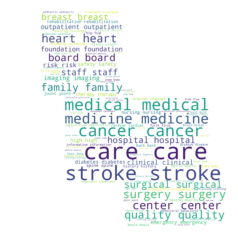

In [117]:
#Draw a wordcloud based on frequent terms for the state of California
#Source: http://clipart-library.com/clipart/pcodoqRRi.htm
california_outline = np.array(Image.open("state_of_california_blue.gif"))
wordcloud = WordCloud(background_color="white",width=1200, height=800,prefer_horizontal=1,mask=california_outline, random_state=42).generate(most_common_words_str)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('california_word_cloud.png')

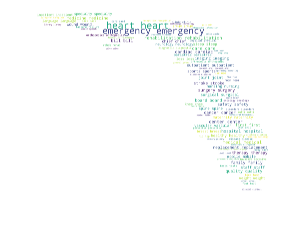

In [118]:
#Draw a wordcloud based on frequent terms for the state of Florida
most_commonfl_words_str = ""
for word in state_terms['FL'].most_common(100):
    most_commonfl_words_str += str(word[0]+" ")*word[1]

florida_outline = np.array(Image.open("florida_outline_v2.png"))
wordcloud = WordCloud(background_color="white",width=1200, height=800,prefer_horizontal=1,mask=florida_outline, random_state=42).generate(most_commonfl_words_str)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('florida_word_cloud.png')

In [119]:
#Check how many types of hospitals in dataset
df_merged['NAICS_DESC'].value_counts()

General Medical And Surgical Hospitals                          180
Hospitals, General Medical And Surgical                           9
Children'S Hospitals, General                                     3
Rehabilitation Hospitals (Except Alcoholism, Drug Addiction)      3
Hospitals, Psychiatric (Except Convalescent)                      2
Children's hospitals, general                                     2
Hospitals, general medical and surgical                           1
Name: NAICS_DESC, dtype: int64

In [120]:
# Compute the correlation matrix, to see if there are any interesting ones
corr = df_merged.corr()

In [121]:
corr

,number_of_terms,ZIP,POPULATION,COUNTYFIPS,LATITUDE,LONGITUDE,NAICS_CODE,ST_FIPS,BEDS
number_of_terms,1.000000,-0.092610,0.274329,0.182267,-0.083358,0.087285,-0.006871,0.181590,0.274329
ZIP,-0.092610,1.000000,-0.133248,-0.421849,-0.154667,-0.921542,0.121238,-0.423787,-0.133248
POPULATION,0.274329,-0.133248,1.000000,0.030275,-0.173077,0.113853,-0.069508,0.029558,1.000000
COUNTYFIPS,0.182267,-0.421849,0.030275,1.000000,0.345165,0.460458,-0.077815,0.999968,0.030275
LATITUDE,-0.083358,-0.154667,-0.173077,0.345165,1.000000,0.201146,0.003558,0.346345,-0.173077
LONGITUDE,0.087285,-0.921542,0.113853,0.460458,0.201146,1.000000,-0.117563,0.461645,0.113853
NAICS_CODE,-0.006871,0.121238,-0.069508,-0.077815,0.003558,-0.117563,1.000000,-0.077461,-0.069508
ST_FIPS,0.181590,-0.423787,0.029558,0.999968,0.346345,0.461645,-0.077461,1.000000,0.029558
BEDS,0.274329,-0.133248,1.000000,0.030275,-0.173077,0.113853,-0.069508,0.029558,1.000000


In [122]:
#Extract state, NAICS, and terms
df_state_naics_terms = df_merged[["STATE", "NAICS_DESC","number_of_terms"]]

In [123]:
df_state_naics_terms.head()

,STATE,NAICS_DESC,number_of_terms
0,FL,General Medical And Surgical Hospitals,130
1,ME,"Hospitals, General Medical And Surgical",21
2,IA,General Medical And Surgical Hospitals,129
3,CA,General Medical And Surgical Hospitals,718
4,IL,General Medical And Surgical Hospitals,600


In [124]:
#group by domain and concatenate terms
df_grouped_by_state = df_state_naics_terms.groupby(['STATE','NAICS_DESC']).apply(lambda x: x.sum())

In [125]:
#rename index from domain to url
#remove extra 'domain' column
df_grouped_by_state.index.names = ['state_key','naics_key']
df_grouped_by_state.drop('STATE', axis=1, inplace=True)

In [126]:
df_grouped_by_state.drop('NAICS_DESC', axis=1, inplace=True)

In [127]:
df_grouped_by_state.head()

number_of_terms
state_key naics_key                                                    
AL        General Medical And Surgical Hospitals                    461
AR        General Medical And Surgical Hospitals                   1238
AZ        General Medical And Surgical Hospitals                    148
CA        General Medical And Surgical Hospitals                   7605
          Hospitals, Psychiatric (Except Convalescent)              431

In [128]:
#reset index
df_grouped_by_state.reset_index(drop=False, inplace=True)

In [129]:
df_grouped_by_state.head()

,state_key,naics_key,number_of_terms
0,AL,General Medical And Surgical Hospitals,461
1,AR,General Medical And Surgical Hospitals,1238
2,AZ,General Medical And Surgical Hospitals,148
3,CA,General Medical And Surgical Hospitals,7605
4,CA,"Hospitals, Psychiatric (Except Convalescent)",431


In [130]:
#Plot by state, type of hoslital (NAICS) and number of unique terms
sns.set()

# Load the pivot needed for heatmap
heatmap_data = df_grouped_by_state.pivot("state_key", "naics_key","number_of_terms")



In [131]:
heatmap_data.fillna(0, inplace=True)
# heatmap_data.naics_key = heatmap_data.naics_key.astype(int)

In [132]:
type(heatmap_data)

pandas.core.frame.DataFrame

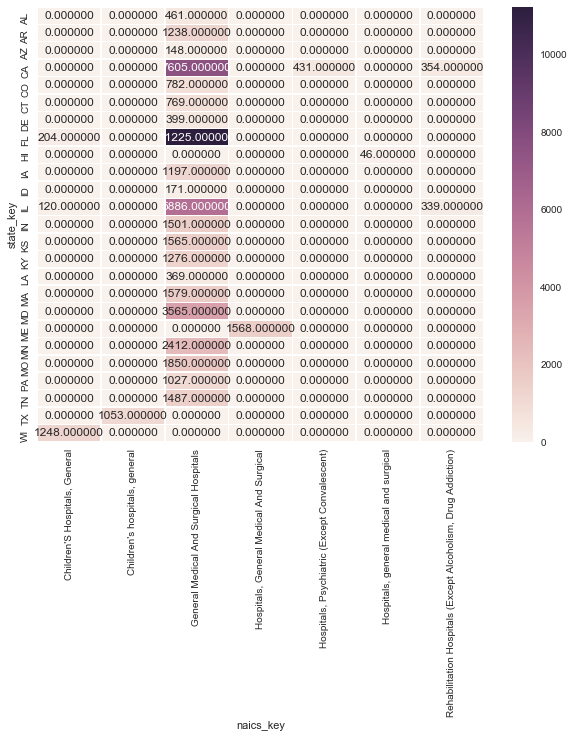

In [133]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt="f", linewidths=.5, ax=ax)

In [134]:
df_merged.head()

,url,terms,number_of_terms,NAME,ADDRESS,CITY,STATE,ZIP,POPULATION,COUNTY,...,LONGITUDE,NAICS_CODE,NAICS_DESC,SOURCE,VAL_DATE,WEBSITE,STATE_ID,ST_FIPS,OWNER,BEDS
0,mercymiami.com,"{anesthesiology, maternity, Paul, behavioral, ...",130,Mercy Hospital,3663 S Miami Ave,Miami,FL,33133,473,Miami-Dade,...,-80.2144,622210,General Medical And Surgical Hospitals,http://www.fgdl.org/metadataexplorer/explorer.jsp,2014-02-10T00:00:00.000Z,http://mercymiami.com/,9878,12,Non-profit,473
1,www.acadiahospital.org,"{Parkinson, CBT, Battle, Suboxone, Scott, May,...",21,The Acadia Hospital,268 Stillwater Avenue,Bangor,ME,4401,68,Penobscot,...,-68.7633,622210,"Hospitals, General Medical And Surgical",http://megis.maine.gov/catalog,2014-02-10T00:00:00.000Z,http://www.acadiahospital.org,Not Available,23,Non-profit,68
2,www.adaircountyhealthsystem.org,"{extreme, winter, spring, symptoms, place, han...",129,Adair County Memorial Hospital,Rr #2 Po Box 100,Greenfield,IA,50849,18,Adair,...,-94.4520,622210,General Medical And Surgical Hospitals,ftp://ftp.igsb.uiowa.edu/gis_library/IA_State/...,2014-03-12T00:00:00.000Z,http://www.adaircountyhealthsystem.org,Not Available,19,Government - Local,18
3,www.adventisthealth.org,"{maternity, spring, large, symptoms, armenia, ...",718,St. Helena Hospital - Clearlake,15630 18Th Ave - Hwy 53,Clearlake,CA,95422,25,Lake,...,-122.6200,622210,General Medical And Surgical Hospitals,http://www.oshpd.ca.gov/HID/Products/Listings....,2014-02-10T00:00:00.000Z,http://www.adventisthealth.org,Not Available,6,Non-profit,25
4,www.advocatehealth.com,"{maternity, powder, neonatology, symptoms, den...",600,Advocate Condell Medical Center,801 S Milwaukee Ave,Libertyville,IL,60048,279,Lake,...,-87.9577,622210,General Medical And Surgical Hospitals,https://data.illinois.gov/,2014-03-12T00:00:00.000Z,http://www.advocatehealth.com/condell/,140202,17,Non-profit,279


In [135]:
#Convert set items into str to search with contains
df_merged['terms_tx'] = df_merged['terms'].apply(str)

In [136]:
#Extract those hospital where 'cancer' was found
df_hospitals_with_term_cancer = df_merged[df_merged['terms_tx'].str.contains('cancer')]

In [137]:
df_hospitals_with_term_cancer.head()

,url,terms,number_of_terms,NAME,ADDRESS,CITY,STATE,ZIP,POPULATION,COUNTY,...,NAICS_CODE,NAICS_DESC,SOURCE,VAL_DATE,WEBSITE,STATE_ID,ST_FIPS,OWNER,BEDS,terms_tx
0,mercymiami.com,"{anesthesiology, maternity, Paul, behavioral, ...",130,Mercy Hospital,3663 S Miami Ave,Miami,FL,33133,473,Miami-Dade,...,622210,General Medical And Surgical Hospitals,http://www.fgdl.org/metadataexplorer/explorer.jsp,2014-02-10T00:00:00.000Z,http://mercymiami.com/,9878,12,Non-profit,473,"{'anesthesiology', 'maternity', 'Paul', 'behav..."
2,www.adaircountyhealthsystem.org,"{extreme, winter, spring, symptoms, place, han...",129,Adair County Memorial Hospital,Rr #2 Po Box 100,Greenfield,IA,50849,18,Adair,...,622210,General Medical And Surgical Hospitals,ftp://ftp.igsb.uiowa.edu/gis_library/IA_State/...,2014-03-12T00:00:00.000Z,http://www.adaircountyhealthsystem.org,Not Available,19,Government - Local,18,"{'extreme', 'winter', 'spring', 'symptoms', 'p..."
3,www.adventisthealth.org,"{maternity, spring, large, symptoms, armenia, ...",718,St. Helena Hospital - Clearlake,15630 18Th Ave - Hwy 53,Clearlake,CA,95422,25,Lake,...,622210,General Medical And Surgical Hospitals,http://www.oshpd.ca.gov/HID/Products/Listings....,2014-02-10T00:00:00.000Z,http://www.adventisthealth.org,Not Available,6,Non-profit,25,"{'maternity', 'spring', 'large', 'symptoms', '..."
4,www.advocatehealth.com,"{maternity, powder, neonatology, symptoms, den...",600,Advocate Condell Medical Center,801 S Milwaukee Ave,Libertyville,IL,60048,279,Lake,...,622210,General Medical And Surgical Hospitals,https://data.illinois.gov/,2014-03-12T00:00:00.000Z,http://www.advocatehealth.com/condell/,140202,17,Non-profit,279,"{'maternity', 'powder', 'neonatology', 'sympto..."
6,www.altabatessummit.org,"{atrial, gender, anvil, ann, gynecology, bmi, ...",187,Mpi Chemical Dependency Recovery Hospital,"3012 Summit Street, 5Th Floor",Oakland,CA,94609,24,Alameda,...,622310,"Rehabilitation Hospitals (Except Alcoholism, D...",http://www.oshpd.ca.gov/HID/Products/Listings....,2014-02-10T00:00:00.000Z,http://www.altabatessummit.org/mpi/,Not Available,6,Non-profit,24,"{'atrial', 'gender', 'anvil', 'ann', 'gynecolo..."


In [143]:
df_hospitals_with_term_cancer.shape

(123, 23)

In [138]:
df_hospitals_with_term_cancer[['CITY','LATITUDE','LONGITUDE']]

,CITY,LATITUDE,LONGITUDE
0,Miami,25.7402,-80.2144
2,Greenfield,41.3038,-94.4520
3,Clearlake,38.9356,-122.6200
4,Libertyville,42.2742,-87.9577
6,Oakland,37.8193,-122.2640
9,Little Rock,34.7426,-92.2924
13,Jacksonville Beach,30.2734,-81.3983
14,Primghar,43.0888,-95.6237
16,Milford,38.9070,-75.4329
17,Montebello,34.0146,-118.1000


In [139]:
#Get longitude and latitude of cities which hospital that were
#found to have term
cities_location = []
for index, row in df_hospitals_with_term_cancer.iterrows():
    cities_location.append((row['LONGITUDE'], row['LATITUDE'],row['CITY']))

In [140]:
#Create list of hospitals in cities that match
#the search record "Cancer" 
#Use this to determine the size of the marker on map
cities_counter = Counter()

for city in df_hospitals_with_term_cancer['CITY']:
    cities_counter.update([city])


In [141]:
cities_counter['Chicago']

6

/Users/agamino/anaconda/envs/py3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/agamino/anaconda/envs/py3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


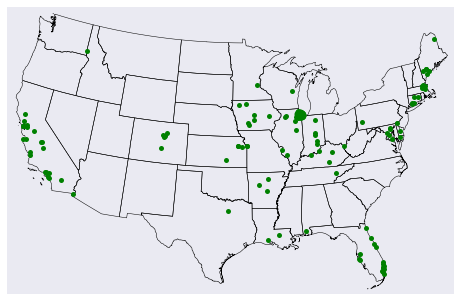

In [142]:
#Draw map of cities with hospitals where term 'cancer' was found
scale = 5

map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=32,lat_2=45,lon_0=-95)

# load the shapefile of the US
map.readshapefile('st99_d00', name='states', drawbounds=True)

# Get the location of each city and plot it
geolocator = Nominatim()

count = 1
for (longitude,latitude,city) in cities_location:
    x, y = map(longitude, latitude)
    #Get number of hospitals in that city 
    count = cities_counter[city]
    map.plot(x,y,marker='o',color='Green',markersize=int(math.sqrt(count))*scale)
plt.show()
plt.savefig('cities_with_cancer_facilities_from_url.png')